In [1]:
from PIL import Image
from scipy.io import loadmat
import numpy as np
from pathlib import Path
from tqdm import tqdm
import itertools
from scipy.ndimage.morphology import distance_transform_edt
from collections import Counter
from itertools import chain
import json
import torch

from utils.show import show_layers_from_mask, show_layers_from_boundary

                        
def boundary_length_distribution(folder):
    lengths = []
    for file in folder:
        data = loadmat(file)
        for bscan in data["layerMaps"]:
            x_inds, _ = np.where(~np.isnan(bscan))
            if x_inds.any():
                lengths.append(x_inds[-1] - x_inds[0])
    return lengths


def boundary_middle_distribution(folder):
    middles = []
    for file in folder:
        data = loadmat(file)
        for bscan in data["layerMaps"]:
            x_inds, _ = np.where(~np.isnan(bscan))
            if x_inds.any():
                middles.append(x_inds[len(x_inds) // 2])
    return middles
            

                
def create_boundary_mask(boundary_array, height):
    mask = np.zeros((height, boundary_array.shape[1]), dtype="uint8")
    for col_idx, col in enumerate(boundary_array.T):
        if ~np.isnan(col).any():
            for boundary in col:
                mask[int(boundary), col_idx] = 1
    return mask


def create_layer_mask(boundary_array, height):
    mask = np.zeros((height, boundary_array.shape[1]), dtype="uint8")
    for col_idx, col in enumerate(boundary_array.T):
        prev_boundary = 0
        for boundary_idx, boundary in enumerate(col):
            mask[prev_boundary:int(boundary) + 1, col_idx] = boundary_idx
            prev_boundary = int(boundary) + 1
        mask[prev_boundary:, col_idx] = boundary_idx + 1
    return mask


def create_patches(img, lyr, patch_width, fluid):
    idx = np.where((np.isnan(lyr)).any(axis=0))[0]
    diff = np.diff(idx)
    useful_parts = diff >= patch_width
    useful_lengths = diff[useful_parts]
    useful_start_idx = idx[np.pad(useful_parts, (0, 1), constant_values=[False])]
    for ustart, ulength in zip(useful_start_idx, useful_lengths):
        number_of_shifts = (ulength - 1) // patch_width
        for shift_idx in range(number_of_shifts):
            indices = (slice(None), slice(
                ustart + 1 + shift_idx * patch_width, ustart + 1 + (shift_idx + 1) * patch_width
            ))
            mid_list.append(int((ustart + 1 + shift_idx * patch_width + ustart + 1 + (shift_idx + 1) * patch_width) / 2))
            img_patch = img[indices]
            lyr_patch = lyr[indices]
            fluid_patch = fluid[indices]
            if np.isnan(fluid_patch).any():
                fluid_patch = np.zeros_like(img_patch)
            else:
                fluid_patch = fluid_patch.astype(img_patch.dtype)
                fluid_patch[fluid_patch != 0] = 1
            mask = create_layer_mask(lyr_patch, img_patch.shape[0])
            yield img_patch, mask, fluid_patch, lyr_patch.T.tolist()
            
            
def generate_dme_dataset(input_dir, output_dir, patch_width):
    files = list(Path(input_dir).glob("*"))
    output_dir = Path(output_dir)
    output_dir.mkdir()
    cnt = 0
    boundary_indices_dict = {}
    layer_widths_dict = {}
    for file in tqdm(files, desc="data generation"):
        data = loadmat(file)
        layers = data["manualLayers1"].transpose((2, 0, 1))
        images = data["images"].transpose((2, 0, 1))
        fluids = data["manualFluid1"].transpose((2, 0, 1))
        for idx, (image, layer, fluid) in enumerate(zip(images, layers, fluids)):
            patch_generator = create_patches(image, layer, patch_width, fluid)
            for img, mask, fluid_patch, boundary_indices_list in patch_generator:
                Image.fromarray(img).save(output_dir / f"img_{cnt}.png")
                Image.fromarray(mask).save(output_dir / f"mask_{cnt}.png")
                Image.fromarray(fluid_patch).save(output_dir / f"fluid_{cnt}.png")
                boundary_indices_dict[cnt] = boundary_indices_list
                cnt += 1
    with open(output_dir / "boundary_indices.json", "w") as boundary_file:
        json.dump(boundary_indices_dict, boundary_file)

# LOAD FILES

In [2]:
amd = list(Path("../../dataset/raw/AMD/").glob("*"))
control = list(Path("../../dataset/raw/Control/").glob("*"))
# dme = list(Path("../../dataset/raw/2015_BOE_Chiu/").glob("*"))
dme = list(Path("../../dataset/raw/1-5").glob("*"))

In [3]:
maxval = 0
minval = 496

for file in dme:
    data = loadmat(file)
    lyrs = data["manualLayers1"]
    currmax = lyrs[~np.isnan(lyrs)].max()
    currmin = lyrs[~np.isnan(lyrs)].min()
    maxval = currmax if currmax > maxval else maxval
    minval = currmin if currmin < minval else minval

In [4]:
print(minval)
print(maxval)

46.0
307.0


# DME

In [152]:
data = loadmat(dme[0])
np.where((~np.isnan(data["manualFluid1"])).any(axis=(0, 1)))[0]

array([10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50])

In [153]:
# idx = 30
idx = 25
img = data["images"][..., idx]
lyr1 = data["manualLayers1"][..., idx]
lyr2 = data["manualLayers2"][..., idx]
fluid1 = data["manualFluid1"][..., idx]
fluid2 = data["manualFluid2"][..., idx]


Image.fromarray(img).show()
# show_layers_from_boundary(img, lyr).show()
show_layers_from_boundary(img, lyr1, fluid=fluid1).show()
# show_layers_from_boundary(img, lyr2, fluid=fluid2).show()

In [7]:
img.shape

(496, 768)

# Plot boundary mask

In [80]:
from utils.misc import get_loaders, get_fluid_boundary
import torch.nn.functional as F

In [91]:
train_dl, valid_dl, mean_std = get_loaders("../../generated", True, 496, 1, None, 2)
fluid_g = ((x, (mask, fluid)) for x, (mask, fluid) in train_dl if fluid.any())

In [94]:
# x, (y, f) = next(fluid_g)
yf = y.clone()
yf[f.bool()] = 9
show_layers_from_mask(x.squeeze(), yf.squeeze(), mean_std).convert(mode="RGB").show()
boundary = F.pad(y[:, 1:, :] - y[:, :-1, :], (0, 0, 0, 1), "constant", 0)
fmask = get_fluid_boundary(f)
bf = torch.logical_or(boundary, fmask)
Image.fromarray(bf.byte().squeeze().numpy() * 255).convert(mode="RGB").save("mask.png")

In [163]:
fluid = bf.squeeze().numpy()
orig_img = ((x.squeeze() * mean_std[1] + mean_std[0]) * 255).clip(0).numpy()

img2 = Image.fromarray(
    np.array([
        np.ones_like(fluid, dtype="uint8") * 100,
        np.ones_like(fluid, dtype="uint8") * 190,
        np.ones_like(fluid, dtype="uint8") * 255]).transpose((1, 2, 0)), mode="HSV")

img = Image.fromarray(np.array([
    np.zeros_like(orig_img).astype("uint8"),
    np.zeros_like(orig_img).astype("uint8"),
    orig_img.astype("uint8"),]).transpose((1, 2, 0)), mode="HSV")

Image.composite(img2, img, Image.fromarray(fluid.astype("uint8") * 255)).convert(mode="RGB").save("img_with_b.png")
img.show()
Image.fromarray(fluid.astype("uint8") * 255).show()

In [136]:
orig_img.min()

0.0

In [102]:
Image.composite?

## Add fluid boundary weighting

In [242]:
# numpy version

shifted = fluid[:, 1:] - fluid[:, :-1]
x, y = np.where(shifted == -1)
y = y - 1
shifted[shifted != 1] = 0
shifted[x, y] = -1
shifted[shifted != 0] = 1
mask1 = np.pad(shifted, ((0, 0), (1, 0)), "constant", constant_values=0)
shifted = fluid[1:, :] - fluid[:-1, :]
x, y = np.where(shifted == -1)
x = x - 1
shifted[shifted != 1] = 0
shifted[x, y] = -1
shifted[shifted != 0] = 1
mask2 = np.pad(shifted, ((1, 0), (0, 0)), "constant", constant_values=0)
mask = np.logical_or(mask1, mask2).astype(float)


# torch version
shifted = f[:, 1:] - f[:, :-1]
x, y = torch.where(shifted == -1)
y = y - 1
shifted[shifted != 1] = 0
shifted[x, y] = 1
mask1 = torch.nn.functional.pad(shifted, (1, 0, 0, 0), "constant", 0)
shifted = f[1:, :] - f[:-1, :]
x, y = torch.where(shifted == -1)
x = x - 1
shifted[shifted != 1] = 0
shifted[x, y] = 1
mask2 = torch.nn.functional.pad(shifted, (0, 0, 1, 0), "constant", 0)
mask = torch.logical_or(mask1, mask2).int()

In [7]:
idx = 12
img = np.array(Image.open(f"../../generated/DME_496/img_{idx}.png"))
lyr = np.array(Image.open(f"../../generated/DME_496/mask_{idx}.png"))

In [8]:
show_layers_from_mask_array(img, lyr).show()

In [13]:
show_layers_from_boundary_array(img, lyr2.T).show()
show_layers_from_boundary_array(img, lyr.T).show()

### Compute segmented length

In [320]:
data = loadmat("../../dataset/raw/2015_BOE_Chiu/Subject_02.mat")

In [321]:
idx = 28

In [322]:
img = data["images"][..., idx]
lyr = data["manualLayers1"][..., idx]

In [323]:
show_layers_from_boundary_array(img, lyr.T).show()

In [65]:
segmented_length = list()

for d in range(10):
    data = loadmat(dme[d])
    for lyr_ind in range(61):
        m1 = data["manualLayers1"][..., lyr_ind]
        m2 = data["manualLayers2"][..., lyr_ind]
        lengths = [] 
        if (~np.isnan(m1)).any():
            w_idx = np.where(~np.isnan(m1))[1]
            delta = w_idx[-1] - w_idx[0]
            lengths.append(delta)
        else:
            lengths.append(0)
        if (~np.isnan(m2)).any():
            w_idx = np.where(~np.isnan(m2))[1]
            delta = w_idx[-1] - w_idx[0]
            lengths.append(delta)
        else:
            lengths.append(0)
        if sum(lengths):
            segmented_length.append(tuple(lengths))
            
Counter(segmented_length)

Counter({(523, 523): 33,
         (547, 547): 11,
         (535, 535): 11,
         (541, 541): 33,
         (505, 505): 11,
         (499, 499): 11})

In [5]:
dme496img = sorted(list(Path("../../generated/DME_496/").glob("img*")))
dme496mask = sorted(list(Path("../../generated/DME_496").glob("mask*")))

In [6]:
img = np.array(Image.open(dme496img[0]))
mask = np.array(Image.open(dme496mask[0]))

In [8]:
show_layers_from_mask_array(img, mask).show()

# There are parts where not all the layers are annotated

In [6]:
# for d in range(10):
#     data = loadmat(dme[d])
#     lyr = data["manualLayers1"]
#     if (np.isnan(lyr).any(axis=0) != np.isnan(lyr).all(axis=0)).sum():
#         print(d)

data = loadmat(dme[0])
lyr = data["manualLayers1"]
img = data["images"]
idx = (np.isnan(lyr).any(axis=0) != np.isnan(lyr).all(axis=0))
np.isnan(lyr[:, idx]).sum(axis=-1)

array([  0,   0,   0,   0, 127,   0,   0,   0])

# Generating the dataset

In [167]:
mid_list = []

In [168]:
patch_width = 64
# generate_dme_dataset("../../dataset/raw/1-5", f"../../generated/training/DME_{patch_width}_t", patch_width)
generate_dme_dataset("../../dataset/raw/6-10", f"../../generated/validation/DME_{patch_width}_t", patch_width)
# len(list(Path(f"../../generated/training/DME_{patch_width}").glob("img*")))

data generation: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


In [24]:
from matplotlib import pyplot as plt

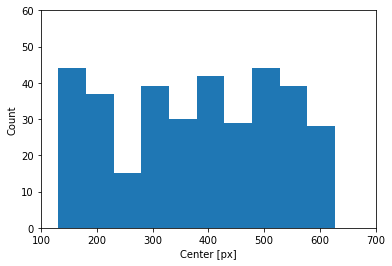

In [169]:
plt.hist(mid_list)
plt.xlabel("Center [px]")
plt.ylabel("Count")
plt.ylim(0, 60)
plt.xlim(100, 700)
plt.savefig("patch_center_distr_validation.png")

(array([44., 37., 15., 39., 30., 42., 29., 44., 39., 28.]),
 array([131. , 180.6, 230.2, 279.8, 329.4, 379. , 428.6, 478.2, 527.8,
        577.4, 627. ]),
 <BarContainer object of 10 artists>)

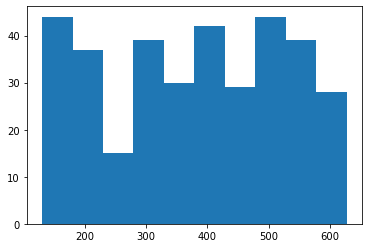

In [29]:
plt.hist(mid_list)

# Proove that the layer mask generation is correct

In [149]:
bmask = create_boundary_mask(lyr[:, 500:600], 496)
lmask = create_layer_mask(lyr[:, 500:600], 496)
diff = np.diff(lmask, axis=0)
(np.pad(diff, ((0, 1), (0, 0)), constant_values=(0,)) != bmask).sum()

0

# AMD

In [10]:
data = loadmat(amd[0])
idx = 30
img = data["images"][:, :, idx]
lyr = data["layerMaps"][idx]

In [14]:
def generate_amd_dataset(amd_dir, control_dir, output_dir, patch_width):
    files = list(
        chain(
            Path(amd_dir).glob("*"),
            Path(control_dir).glob("*")
        )
    )
    output_dir = Path(output_dir)
    output_dir.mkdir()
    cnt = 0
    for file in tqdm(files, desc="data generation"):
        data = loadmat(file)
        layers = data["layerMaps"].transpose((0, 2, 1))
        images = data["images"].transpose((2, 0, 1))
        for idx, (image, layer) in enumerate(zip(images, layers)):
            patch_generator = create_patches(image, layer, patch_width)
            for img, mask in patch_generator:
                Image.fromarray(img).save(output_dir / f"img_{cnt}.png")
                Image.fromarray(mask).save(output_dir / f"mask_{cnt}.png")
                cnt += 1

In [34]:
patch_width = 736
generate_amd_dataset(
    "../../dataset/raw/AMD/",
    "../../dataset/raw/Control/",
    f"../../generated/AMD_{patch_width}",
    patch_width
)

data generation: 100%|██████████| 384/384 [04:31<00:00,  1.42it/s]


In [35]:
len(list(Path("../../generated/AMD_736").glob("img*")))

2901

In [26]:
loadmat(d)

784

In [33]:
736 / 16

46.0

In [11]:
show_layers_from_boundary_array(img, lyr).show()
show_boundary_from_boundary_array(img, lyr).show()